In [301]:
# project for datathon 2019
# main author: Yuxiao Ran
# team: table 15 (Yuxiao Ran, Bingqi Zhou, Yuexiang Zhang)
# data: 4/20/19

In [333]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import warnings; warnings.simplefilter('ignore')

In [307]:
# load datasets
collisions = pd.read_csv("pd_collisions_datasd.csv")
counts = pd.read_csv("traffic_counts_datasd.csv")

In [308]:
# clean data in collisions
collisions_cleaned = collisions[["date_time", "street_name", "street_type", "injured", "killed"]]

In [309]:
# clean data in counts
counts_cleaned = counts[["street_name", "total_count", "count_date"]]

In [310]:
# function that drop exact time in data_time / count_date
def only_date(datetime):
    return datetime[:10]

In [334]:
collisions_cleaned["new_time"] = collisions_cleaned["date_time"].apply(only_date)
collisions_nt = collisions_cleaned.drop("date_time", axis=1)
collisions_nt.head()

,street_name,street_type,injured,killed,new_time
0,CAM DEL ORO,,0,0,2017-01-01
1,ROYAL GORGE,DRIVE,0,0,2017-01-01
2,CRAWFORD,STREET,0,0,2017-01-01
3,VALERIO,TRAIL,0,0,2017-01-01
4,11TH,AVENUE,0,0,2017-01-01


In [313]:
# calculate casualties in collisions
collisions_nt["casualties"] = collisions_nt["injured"] + collisions_nt["killed"]
collisions_cas = collisions_nt.drop(["injured", "killed"], axis=1)
collisions_cas.head()

,street_name,street_type,new_time,casualties
0,CAM DEL ORO,,2017-01-01,0
1,ROYAL GORGE,DRIVE,2017-01-01,0
2,CRAWFORD,STREET,2017-01-01,0
3,VALERIO,TRAIL,2017-01-01,0
4,11TH,AVENUE,2017-01-01,0


In [335]:
counts_cleaned["new_time"] = counts_cleaned["count_date"].apply(only_date)
counts_nt = counts_cleaned.drop("count_date", axis=1)
counts_nt.head()

,street_name,total_count,new_time
0,01 AV,18010,2007-03-13
1,01 AV,20060,2010-03-18
2,01 AV,19597,2013-03-12
3,01 AV,2298,2012-12-11
4,01 AV,15625,2011-09-01


In [315]:
# functions that converts street names, eg: "01ST" -> "01" and "11TH" -> "11"
def st_num(s):
    if re.match(r'\d{2}(ST|ND|RD|TH)', s):
        return s[0:2]
    return s

In [316]:
collisions_cas["street_name"] = collisions_cas["street_name"].apply(st_num)
collisions_cas.head()

,street_name,street_type,new_time,casualties
0,CAM DEL ORO,,2017-01-01,0
1,ROYAL GORGE,DRIVE,2017-01-01,0
2,CRAWFORD,STREET,2017-01-01,0
3,VALERIO,TRAIL,2017-01-01,0
4,11,AVENUE,2017-01-01,0


In [317]:
# function that finds all abbr for street types
def st_type(s):
    if re.search(r'[ ]{1}[A-Z]{2,5}$', s):
        return s.split(" ")[-1]
    return ""
counts_nt["street_name"].apply(st_type).unique()

array(['AV', 'ST', '', 'DR', 'RD', 'BL', 'PL', 'WY', 'PY', 'CR', 'SUR',
       'LN', 'CT', 'PT', 'ML', 'TL', 'GL', 'TR', 'HY'], dtype=object)

In [318]:
collisions_cas["street_type"].unique()

array([' ', 'DRIVE', 'STREET', 'TRAIL', 'AVENUE', 'PLACE', 'COURT',
       'ROAD', 'BOULEVARD', 'PARKWAY', 'WAY', 'COVE', 'CIRCLE', 'LANE',
       'HIGHWAY', 'TERRACE', 'PLAZA', 'MALL', 'ROW', 'POINT', 'WALK',
       'PASEO', 'SQUARE', 'RAMP', 'DRIVEWAY', 'KNOLLS', nan, 'LIGHTS'],
      dtype=object)

In [319]:
# credit to B.Zhou
brief_to_full = {'AV': 'AVENUE', 'BL': 'BOULEVARD', 'CR': 'CIRCLE', 'CT': 'COURT', 'DR': 'DRIVE', 'HY': 'HIGHWAY', 'LN': 'LANE', \
                'ML': 'MALL', 'PL': 'PLACE', 'PT': 'POINT', 'PY': 'PARKWAY', 'RD': 'ROAD', 'ST': 'STREET', 'TL': 'TRAIL', \
                'TR': 'TERRACE', 'WY': 'WAY', "": " "}

In [320]:
st_type_dict = {v: k for k, v in brief_to_full.items()}
def find_abbr(s):
    if s in st_type_dict:
        return " " + st_type_dict[s]
    return ""

In [321]:
# integrate street names and street types in collisions
collisions_abbr = collisions_cas.copy(deep=True)
collisions_abbr["street_name"] = collisions_abbr["street_name"] + collisions_abbr["street_type"].apply(find_abbr)
collisions_abbr = collisions_abbr.drop("street_type", axis=1)
collisions_abbr.head()

,street_name,new_time,casualties
0,CAM DEL ORO,2017-01-01,0
1,ROYAL GORGE DR,2017-01-01,0
2,CRAWFORD ST,2017-01-01,0
3,VALERIO TL,2017-01-01,0
4,11 AV,2017-01-01,0


In [322]:
# group counts by street names
counts_by_st_name = counts_nt.groupby("street_name").mean()
counts_by_st_name = counts_by_st_name.reset_index()
counts_by_st_name.head()

,street_name,total_count
0,01 AV,8810.594937
1,02 AV,3676.230769
2,03 AV,3852.904762
3,04 AV,9194.922078
4,05 AV,9760.908046


In [326]:
# group collisions by street names, and sum casualties
# only consider streets that have more than 5 casualties
collisions_unformed = collisions_abbr.groupby("street_name").sum()
collisions_sorted_by_casualties = collisions_unformed.sort_values("casualties", ascending=False)
collisions_dangerous = collisions_sorted_by_casualties[collisions_sorted_by_casualties["casualties"] >= 5]
collisions_dangerous = collisions_dangerous.reset_index()
collisions_dangerous.head()

,street_name,casualties
0,UNIVERSITY AV,362
1,EL CAJON BL,358
2,MIRAMAR RD,316
3,MIRA MESA BL,237
4,OCEAN VIEW BL,235


In [327]:
# combine counts and collisions
combined = collisions_dangerous.set_index("street_name").join(counts_by_st_name.set_index("street_name")).dropna()
combined = combined.rename({"total_count": "traffic_level"}, axis=1)
combined.head()

,casualties,traffic_level
street_name,,
UNIVERSITY AV,362,20583.447115
EL CAJON BL,358,25301.591667
MIRAMAR RD,316,50901.265625
MIRA MESA BL,237,51561.920455
OCEAN VIEW BL,235,9537.205882


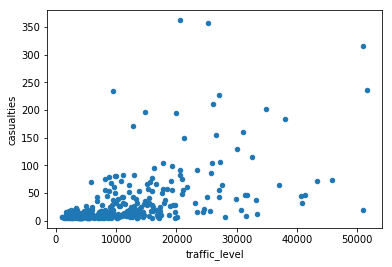

In [328]:
# plot the possible relationship between traffic level and casualties
combined.plot.scatter("traffic_level", "casualties")

In [329]:
# compute risk = casualties / traffic_level
combined_with_risk = combined.copy(deep=True)
combined_with_risk["risk"] = combined["casualties"] / combined["traffic_level"]
combined_with_risk = combined_with_risk.sort_values("risk", ascending=False)
combined_with_risk.head()

,casualties,traffic_level,risk
street_name,,,
OCEAN VIEW BL,235,9537.205882,0.024640
UNIVERSITY AV,362,20583.447115,0.017587
EL CAJON BL,358,25301.591667,0.014149
MARKET ST,172,12853.467213,0.013382
IMPERIAL AV,196,14720.911111,0.013314


Text(0,0.5,'Risk of Driving')

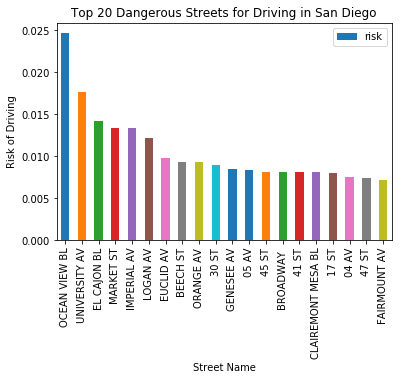

In [330]:
# plot 1: top 20 dangerous streets in SD
result_risk = combined_with_risk.head(20).plot(kind="bar", y="risk", title="Top 20 Dangerous Streets for Driving in San Diego")
result_risk.set_xlabel("Street Name")
result_risk.set_ylabel("Risk of Driving")

Text(0,0.5,'Casualties in History')

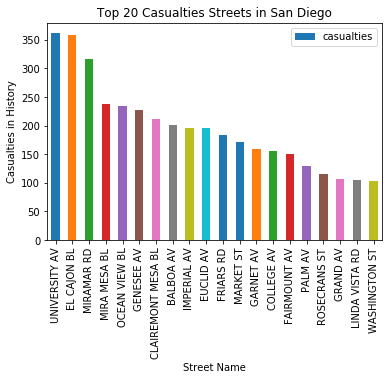

In [331]:
# plot 2: streets with top 20 casualties in SD
result_cas = combined_with_risk.sort_values("casualties", ascending=False).head(20).plot(kind="bar", y="casualties", \
                                                                                         title="Top 20 Casualties Streets in San Diego")
result_cas.set_xlabel("Street Name")
result_cas.set_ylabel("Casualties in History")

Text(0,0.5,'Traffic Level')

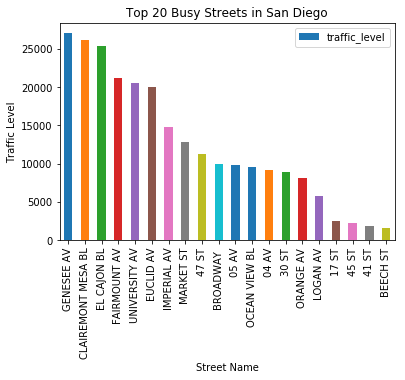

In [332]:
# plot 3: streets with most traffic in SD
result_tl = combined_with_risk.head(20).sort_values("traffic_level", ascending=False).plot(kind="bar", y="traffic_level", \
                                                                                           title="Top 20 Busy Streets in San Diego")
result_tl.set_xlabel("Street Name")
result_tl.set_ylabel("Traffic Level")